In [10]:
import argparse
import os
import random
import torch as t
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision as tv
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [11]:
manualSeed = 42
print("Random seed = ", manualSeed)
random.seed(manualSeed)
t.manual_seed(manualSeed)

Random seed =  42


In [12]:
dataroot = './data/celeba'
num_workers = 2
batch_size=64
image_size=64

c = 10
nc = 1 #no. channels of images
nz = 100
ngf = 64 #no. generator's feature maps
ndf = 64 #no. discriminator's feature maps
num_epochs = 5
lr = .0002
beta1 = .5
ngpu = 1 #no. gpu


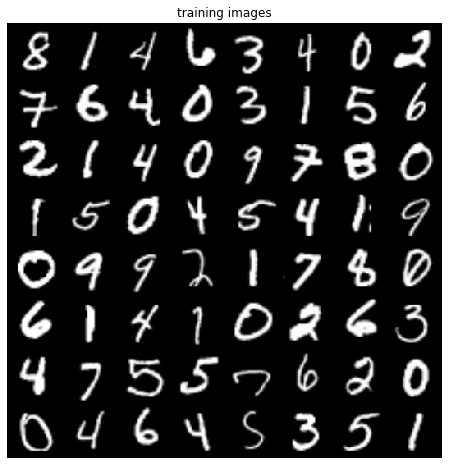

In [13]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
transforms=tv.transforms.Compose([
                               tv.transforms.Resize(image_size),
                               tv.transforms.CenterCrop(image_size),
                               tv.transforms.ToTensor(),
                               tv.transforms.Normalize((0.1307,), (0.3081,)),    
                                ])



# dataset = tv.datasets.ImageFolder(root=dataroot,
#                                  transform=transforms
#                                  ]))
# dataset = tv.datasets.ImageFolder(root=dataroot,

#                            ]))

#dataset = tv.datasets.CIFAR10('./data', train=True, download=True, transform=transforms)
dataset = tv.datasets.MNIST('./data', train=True, download=True, transform=transforms)

dataloader = t.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

device = t.device("cuda:0" if (t.cuda.is_available() and ngpu > 0) else 'cpu')

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [14]:
#now, init model weight according to normal distribution, why?
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        t.nn.init.normal_(m.weight.data, .0, .02)
    elif classname.find('BatchNorm')!= -1:
        t.nn.init.normal_(m.weight.data, 1.0, .02)
        t.nn.init.constant_(m.bias.data, 0.0)

In [15]:
class Generator(t.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = t.nn.Sequential(
            # input is Z, going into a convolution
            t.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            t.nn.BatchNorm2d(ngf * 8),
            t.nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            t.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf * 4),
            t.nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            t.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf * 2),
            t.nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            t.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf),
            t.nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            t.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            t.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [16]:
netg = Generator(ngpu).to(device)
if (device.type=='cuda') and (ngpu > 1):
    netg = t.nn.DataParallel(netg, list(range(ngpu)))
netg.apply(weight_init)  #apply weight_init recursively to all children
print(netg)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [17]:
for item in netg.children():
    for item2 in item.children():
        print (item2.__class__.__name__)


ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
Tanh


In [18]:
class Discriminator(t.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = t.nn.Sequential(
            # input is (nc) x 64 x 64
            t.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            t.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 2),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            t.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 4),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            t.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 8),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            t.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            t.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [19]:
netd = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netd = t.nn.DataParallel(netd, list(range(ngpu)))
netd.apply(weight_init)
print(netd)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [20]:
criterion = t.nn.BCELoss()
#criterion = t.nn.BCEWithLogitsLoss()

fixed_noise = t.randn(64, nz, 1, 1, device=device)

label_real = 1
label_fake = 0

optimizer_d = optim.Adam(netd.parameters(), lr=lr, betas=(beta1, .999))
optimizer_g = optim.Adam(netg.parameters(), lr=lr, betas=(beta1, .999))


In [23]:
def add_condition(nz, c, n, b_size):
    #TODO: add the class as the precondition for the data into the 
    #INPUT: array of class ground truth c, size of noise nz, number of ground truth classes
            #a noise vector of size (batch, )
    c_onehot =  t.nn.functional.one_hot(c.to(t.int64).clone().detach().to(device), 10).type(t.FloatTensor)
    noise = t.randn(b_size, nz, device=device)
    result = t.cat((noise.squeeze().to(device), c_onehot.to(device)), 1) #ignore batch at dim=0
    return result.unsqueeze(2).unsqueeze(3)

img_list = []
g_loss = []
d_loss = []
iters = 0

print ('Start training')

for epoch in range(num_epochs):
    for i, (img, label) in enumerate(dataloader):
        netd.zero_grad()
        
        #train d
        #train d with all read data batch
        real_cpu = img.to(device)
        b_size = real_cpu.size(0)
        label = t.full((b_size,), label_real, dtype=t.float, device=device) #create a vector [label_real, ...] equal to batch size
        output = netd(real_cpu).view(-1)
        err_d_real = criterion(output, label)
        err_d_real.backward()
        D_x = output.mean().item() #why mean here? mean over all batch values?
        #train d with fake data from g
        noise = add_condition(nz - 10, label, 10, b_size)
        #noise = t.randn(b_size, nz, 1, 1, device=device)
        fake = netg(noise)
        label.fill_(label_fake) #change the gt label, no be [label_fake, ...] instead
        output = netd(fake.detach()).view(-1)
        err_d_fake = criterion(output, label)
        err_d_fake.backward()
        D_G_z1 = output.mean().item() #D(G(z)) over batch of z
        err_d = err_d_real + err_d_fake
        
        optimizer_d.step()
        
        #train g: minimize 1 - D(G(z)) is maximize (D(G(z)))
        netg.zero_grad()
        label.fill_(label_real)
        output=netd(fake).view(-1)
        err_g = criterion(output, label)
        err_g.backward()
        D_G_z2 = output.mean().item()
        
        optimizer_g.step()
        
        if i%50 == 0:
            print (f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] \t Loss_D: {err_d.item():.4f}, Loss_G: {err_g.item():.4f} \t D(x): {D_x} \t D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
        
        g_loss.append(err_g.item())
        d_loss.append(err_d.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with t.no_grad():
                fake = netg(fixed_noise).detach().cpu()
            img_list.append(tv.utils.make_grid(fake, padding=2, normalize=True))    
            
        iters += 1#fine grain iteration 

Start training
[0/5][0/938] 	 Loss_D: 0.0435, Loss_G: 6.4224 	 D(x): 0.9655579328536987 	 D(G(z)): 0.0062 / 0.0028
[0/5][50/938] 	 Loss_D: 0.6065, Loss_G: 2.9220 	 D(x): 0.7288051843643188 	 D(G(z)): 0.2021 / 0.0837
[0/5][100/938] 	 Loss_D: 0.4113, Loss_G: 3.0250 	 D(x): 0.8132352828979492 	 D(G(z)): 0.1411 / 0.0617
[0/5][150/938] 	 Loss_D: 0.2137, Loss_G: 4.0409 	 D(x): 0.9212737083435059 	 D(G(z)): 0.1085 / 0.0264
[0/5][200/938] 	 Loss_D: 0.1283, Loss_G: 3.1958 	 D(x): 0.9149428606033325 	 D(G(z)): 0.0348 / 0.0545
[0/5][250/938] 	 Loss_D: 0.0409, Loss_G: 6.1193 	 D(x): 0.9862305521965027 	 D(G(z)): 0.0260 / 0.0034
[0/5][300/938] 	 Loss_D: 0.0006, Loss_G: 39.7677 	 D(x): 0.9994179010391235 	 D(G(z)): 0.0000 / 0.0000
[0/5][350/938] 	 Loss_D: 0.0000, Loss_G: 39.3414 	 D(x): 0.9999856948852539 	 D(G(z)): 0.0000 / 0.0000
[0/5][400/938] 	 Loss_D: 0.0001, Loss_G: 39.2453 	 D(x): 0.9999224543571472 	 D(G(z)): 0.0000 / 0.0000
[0/5][450/938] 	 Loss_D: 0.0000, Loss_G: 40.0323 	 D(x): 0.99999368

[4/5][250/938] 	 Loss_D: 0.0000, Loss_G: 11.0617 	 D(x): 0.999977707862854 	 D(G(z)): 0.0000 / 0.0000
[4/5][300/938] 	 Loss_D: 0.0000, Loss_G: 11.0256 	 D(x): 0.9999792575836182 	 D(G(z)): 0.0000 / 0.0000
[4/5][350/938] 	 Loss_D: 0.0000, Loss_G: 10.7291 	 D(x): 0.9999922513961792 	 D(G(z)): 0.0000 / 0.0000
[4/5][400/938] 	 Loss_D: 0.0000, Loss_G: 11.4061 	 D(x): 0.9999967813491821 	 D(G(z)): 0.0000 / 0.0000
[4/5][450/938] 	 Loss_D: 0.0000, Loss_G: 11.3493 	 D(x): 0.9999725818634033 	 D(G(z)): 0.0000 / 0.0000
[4/5][500/938] 	 Loss_D: 0.0000, Loss_G: 11.6997 	 D(x): 0.9999940395355225 	 D(G(z)): 0.0000 / 0.0000
[4/5][550/938] 	 Loss_D: 0.0000, Loss_G: 10.9858 	 D(x): 0.9999801516532898 	 D(G(z)): 0.0000 / 0.0000
[4/5][600/938] 	 Loss_D: 0.0000, Loss_G: 11.3251 	 D(x): 0.9999861121177673 	 D(G(z)): 0.0000 / 0.0000
[4/5][650/938] 	 Loss_D: 0.0000, Loss_G: 11.7957 	 D(x): 0.9999963045120239 	 D(G(z)): 0.0000 / 0.0000
[4/5][700/938] 	 Loss_D: 0.0000, Loss_G: 11.6657 	 D(x): 0.999992191791534

In [103]:
real_cpu.shape, netd(real_cpu).view(-1).shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

In [104]:
fake.shape

torch.Size([64, 3, 64, 64])

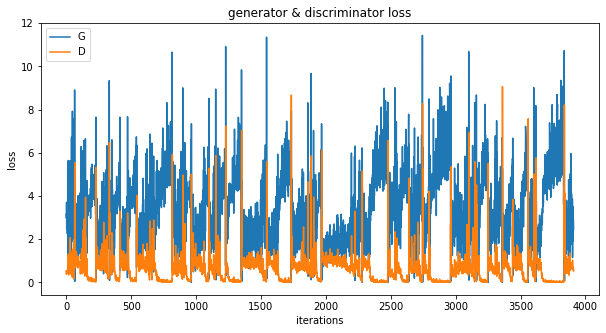

In [105]:
plt.figure(figsize=(10, 5))
plt.title('generator & discriminator loss')
plt.plot(g_loss, label='G')
plt.plot(d_loss, label='D')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()


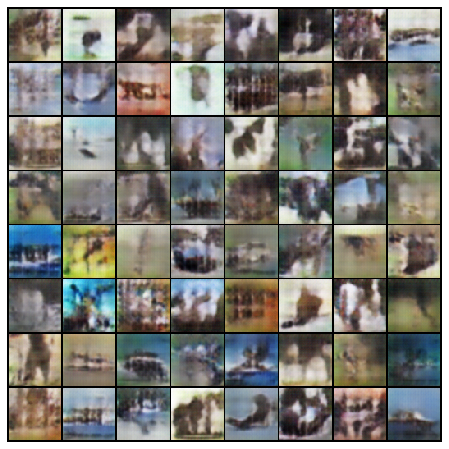

In [106]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

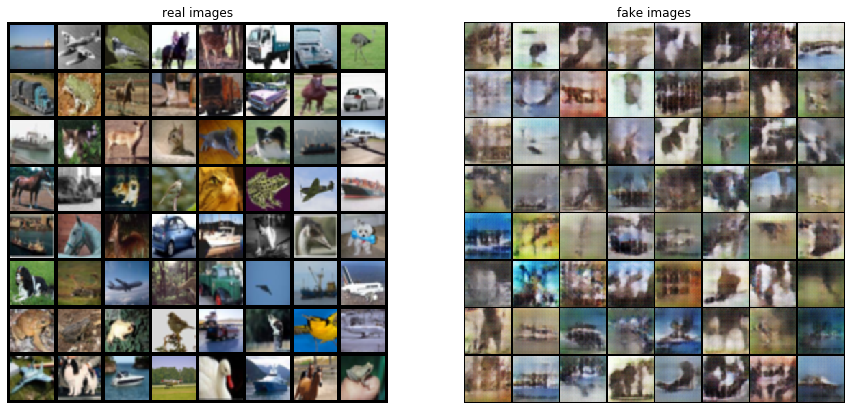

In [107]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('real images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('fake images')
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))


In [119]:
noise.shape

torch.Size([64, 120, 1, 1])